In [87]:
%load_ext autoreload
%autoreload 2
import datetime
import json
import logging
import os
from pprint import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim 
import torchvision.ops as ops
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics

from data_utils.vcoco_dataset import VCOCODataset
from data_utils.combine_labels import CombineLabels
from eval_utils.plot_history import plot_history
from train_loop import train_model, get_predictions, device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Use this to configure all global config.
# The results should always be perfectly reproducible
# if the config is identical.
GLOBAL_CONFIG = {
    'OVERRIDE_LEN_TRAIN': 300,
    'OVERRIDE_LEN_VAL': 100,
    'BATCH_SIZE': 100,
    'FEATURE_EXTRACT': True,  # If true, don't backprop into Resnet weights
    'COMBINE_LABELS': {
        'category_groups': [
            {"throw", "catch"}, {"run", "jump"}, {"hit"},  ## Maybe combine these, into something like "doing something athletic"?
            {"kick"}, # Maybe combine with above, but it's almost exc
            {"stand", "walk"}, {"carry"}, # Maybe combine these, into something like "moving about slowly"
            {"hold"},
            {"sit"},
            {"ride"},
            {"eat"}, {"drink"},  ## Can be combined semantically, images are different tho
            {"talk_on_phone"},
            {"cut"},
            {"ski", "snowboard", "surf", "skateboard"},
            {"smile"},
            {"point"},
            {"read"},
        ],
        'to_remove': {"look", "lay", "work_on_computer"}
    }
}

In [22]:
torch.set_num_threads(8)

In [23]:
logging.basicConfig(level=logging.INFO)

In [24]:
combine_labels_config = GLOBAL_CONFIG['COMBINE_LABELS']
if combine_labels_config is not None:
    combine_labels = CombineLabels(**combine_labels_config)
else:
    combine_labels = None

In [65]:
vc_train = VCOCODataset(
    path_to_vcoco_anns="../v-coco/data/vcoco/vcoco_train.json",
    coco_data_dir="../cocoapi",
    coco_data_type="train2017",
    override_len=GLOBAL_CONFIG['OVERRIDE_LEN_TRAIN'],
    combine_labels=combine_labels,
)

INFO:data_utils.vcoco_dataset:Loading VCOCO annotations...
INFO:data_utils.vcoco_dataset:Done!
INFO:data_utils.vcoco_dataset:Loading coco annotations...


loading annotations into memory...
Done (t=15.41s)
creating index...


INFO:data_utils.vcoco_dataset:Done!


index created!


In [66]:
vc_val = VCOCODataset(
    path_to_vcoco_anns="../v-coco/data/vcoco/vcoco_val.json",
    coco_data_dir="../cocoapi",
    coco_data_type="train2017",
    override_len=GLOBAL_CONFIG['OVERRIDE_LEN_VAL'],
    combine_labels=combine_labels,
)

INFO:data_utils.vcoco_dataset:Loading VCOCO annotations...
INFO:data_utils.vcoco_dataset:Done!
INFO:data_utils.vcoco_dataset:Loading coco annotations...


loading annotations into memory...
Done (t=15.04s)
creating index...


INFO:data_utils.vcoco_dataset:Done!


index created!


In [67]:
print(vc_val.vcoco.n_classes, vc_train.vcoco.n_classes)
print(len(vc_val), len(vc_train))
print(vc_val.vcoco.n_images, vc_train.vcoco.n_images)

17 17
100 300
2867 2533


#### Preload data into the cache.
This is not required, since things are lazily loaded into the cache --
this will happen anyway in the first epoch. Just put it here so we could
add some logging and make sure it worked.

In [68]:
def preload_data(vc_data):
    for i in range(len(vc_data)):
        if i % 500 == 0:
            print(time.ctime(), f"Preloaded {i}")
        # The cache is populated lazily, whenever data is accessed,
        # so this has the side-effect of preloading the data.
        _ = vc_data[i]
    print(time.ctime(), "Done preloading!")

In [69]:
preload_data(vc_train)

Sat Jun  6 23:20:01 2020 Preloaded 0
Sat Jun  6 23:20:04 2020 Done preloading!


In [70]:
preload_data(vc_val)

Sat Jun  6 23:20:05 2020 Preloaded 0
Sat Jun  6 23:20:06 2020 Done preloading!


In [71]:
def visualize_normalized_tensor(vc_data, idx):
    x, y = vc_data[idx]
    cat_names = [vc_data.vcoco.category_names[j] for j in np.where(y == 1)[0]]
    x_for_vis = np.moveaxis(x.data.numpy(), 0, -1)
    plt.imshow(x_for_vis)
    plt.title(f"Annotation index {idx}, categories {cat_names}")

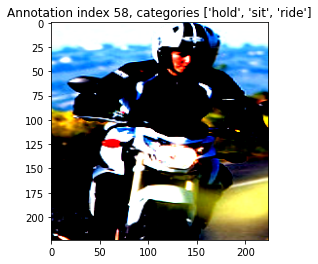

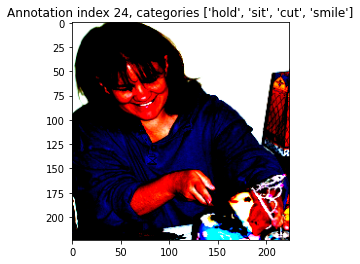

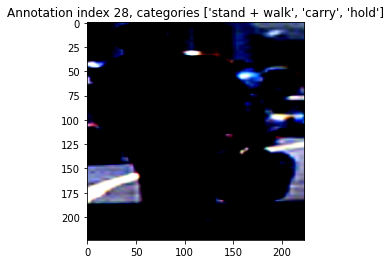

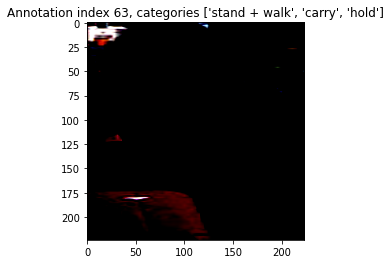

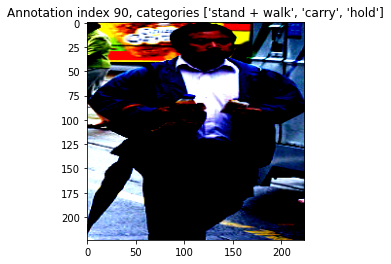

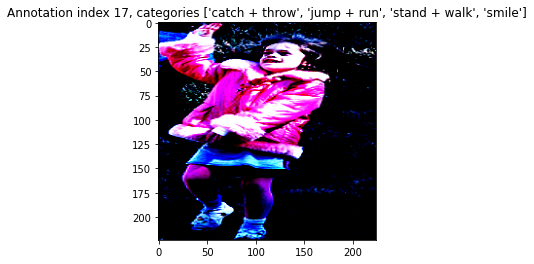

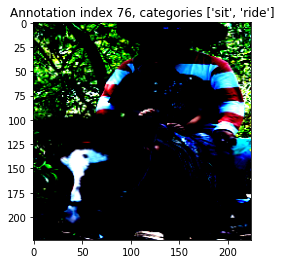

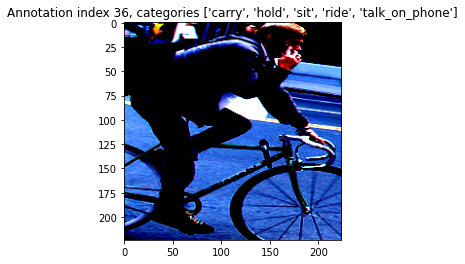

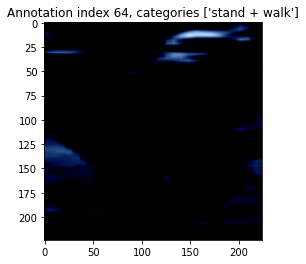

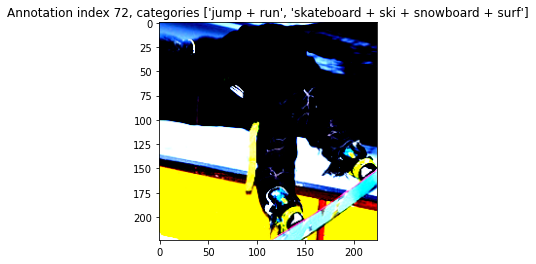

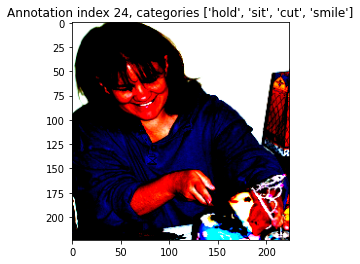

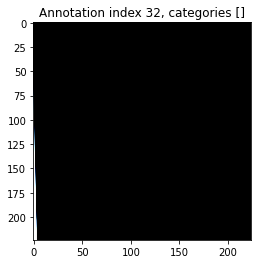

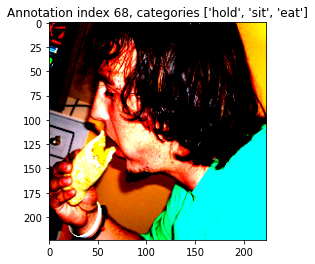

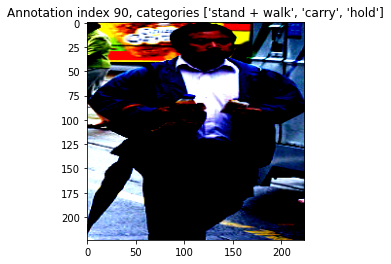

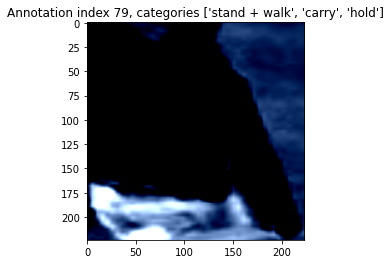

In [72]:
# Sanity check the data by looking at some random images and their labels
for idx in np.random.randint(0, len(vc_val), 15):
    plt.figure()
    visualize_normalized_tensor(vc_val, idx)

### Prepare the data

In [73]:
def create_dataloader(dataset):
    """
    Create a dataloader with our default options
    """
    return DataLoader(dataset, batch_size=GLOBAL_CONFIG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [74]:
dataloaders = {'train': create_dataloader(vc_train), 'val': create_dataloader(vc_val)}

### Prep for training: initialize model and optimizer

In [75]:
model = models.resnet18(pretrained=True)
if GLOBAL_CONFIG['FEATURE_EXTRACT']:
    for param in model.parameters():
        param.requires_grad = False
fc_in_features = model.fc.in_features
model.fc = nn.Linear(in_features=fc_in_features, out_features=vc_train.vcoco.n_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [76]:
print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [77]:
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [78]:
criterion = nn.BCEWithLogitsLoss()

### Train the model

In [85]:
print(time.ctime())
_, auc_history, loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=2)

Sat Jun  6 23:23:05 2020
Epoch 0/1
----------
train Loss: 0.7183; Average AUC: 0.4294
val Loss: 0.6696; Average AUC: 0.4843
Epoch done. Took 20.99021005630493 seconds

Epoch 1/1
----------
train Loss: 0.6469; Average AUC: 0.4871
val Loss: 0.5989; Average AUC: 0.5467
Epoch done. Took 20.369488954544067 seconds

Training complete in 0m 41s
Best val AUc: 0.5467


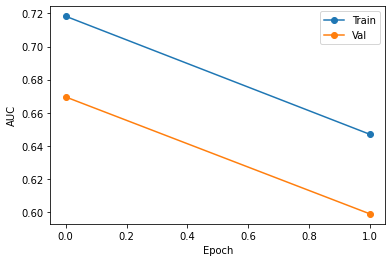

In [92]:
plot_history(loss_history, y_lab="AUC")

In [99]:
def serialize_model_and_data(model, auc_history, loss_history, vc_data):
    now = datetime.datetime.now().strftime("%b_%d_%Y_%H_%M_%S")
    dirname = f"model_dump_{now}"
    os.mkdir(dirname)
    with open(os.path.join(dirname, f"model_{str(model)[:10]}.pth"), "wb") as f:
        torch.save(model, f)
    with open(os.path.join(dirname, "training_metrics.json"), "w") as f:
        json.dump({"auc_history": auc_history, "loss_history": loss_history}, f)
    with open(os.path.join(dirname, "config_and_category_names.json"), "w") as f:
        config_to_dump = dict(GLOBAL_CONFIG)
        
        # Convert sets to lists, otw JSON serialize fails
        if 'COMBINE_LABELS' in config_to_dump:
            config_to_dump['COMBINE_LABELS']['category_groups'] = [list(s) for s in config_to_dump['COMBINE_LABELS']['category_groups']]
            config_to_dump['COMBINE_LABELS']['to_remove'] = list(config_to_dump['COMBINE_LABELS']['to_remove'])
        json.dump({"category_names": vc_data.vcoco.category_names, "config": GLOBAL_CONFIG}, f)

In [100]:
serialize_model_and_data(model, auc_history, loss_history, vc_train)

In [82]:
%%time
print(time.ctime())
o, l = get_predictions(model, dataloaders["val"])

Sat Jun  6 23:22:00 2020
CPU times: user 4.99 s, sys: 211 ms, total: 5.2 s
Wall time: 5.18 s


In [83]:
l.sum() / (l.shape[0] * l.shape[1])  # fraction of positive labels

0.13294117647058823

In [84]:
a = np.asarray([])
for idx in range(vc_train.vcoco.n_classes):
    a = np.append(a, sklearn.metrics.roc_auc_score(l[:, idx], o[:, idx]))
pprint(list(zip(vc_val.vcoco.category_names, a)))
print(f"Mean: {a.mean()}, median: {np.median(a)}")

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.